# Height

In [1]:
#install.packages('ggpubr')

In [2]:
library(bigrquery)
library(tidyverse) 
#imports stringr, dplyr and tidyr
library(ggplot2)
#library(ggpubr) 

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   0.3.5 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.5.0 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [3]:
#Set up some parameters
#Training_time is used for all ML training
training_time=3600*(0.025)

Sys.setenv (TZ = "America/Los_Angeles")
Sys.time()

[1] "2023-10-05 10:13:37 PDT"

In [4]:
# Copy the file from bucket to the directory
system(paste0("gsutil cp gs://fc-secure-1fc7fc53-6581-4bec-bd7a-082b0544112e/alldata88.csv ."), intern=T)

# Load the file into a dataframe
alldata  <- read_csv("alldata88.csv")
#head(alldata)



character(0)

Rows: 300292 Columns: 97
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (4): race, gender, ethnicity, sex_at_birth
dbl (93): person_id, Body_height, BMI, Body_weight, current_age, avg_of_LRR_...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


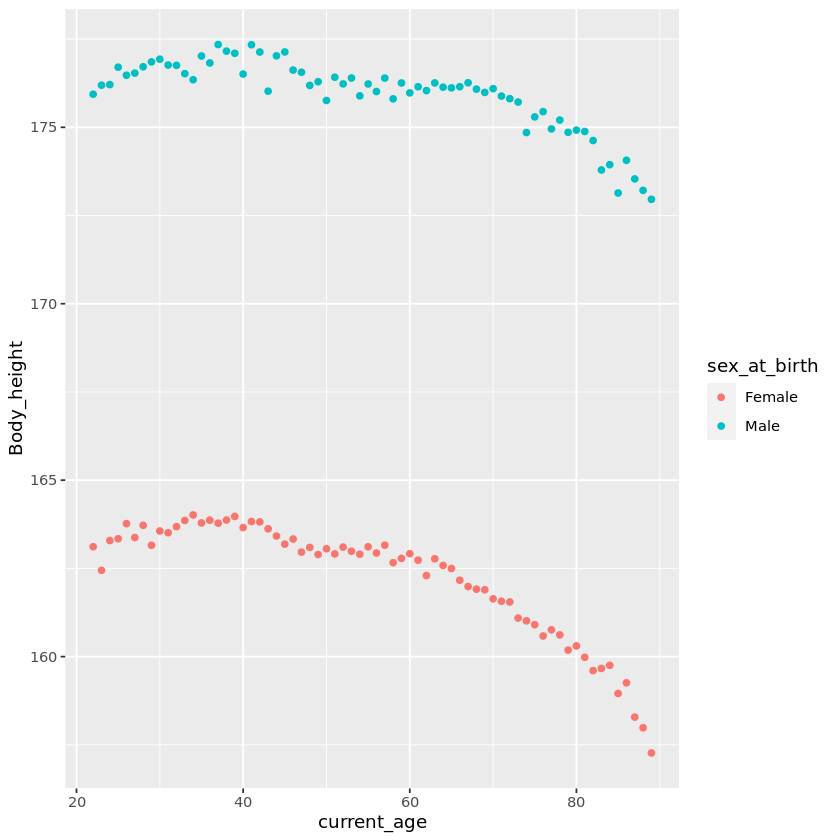

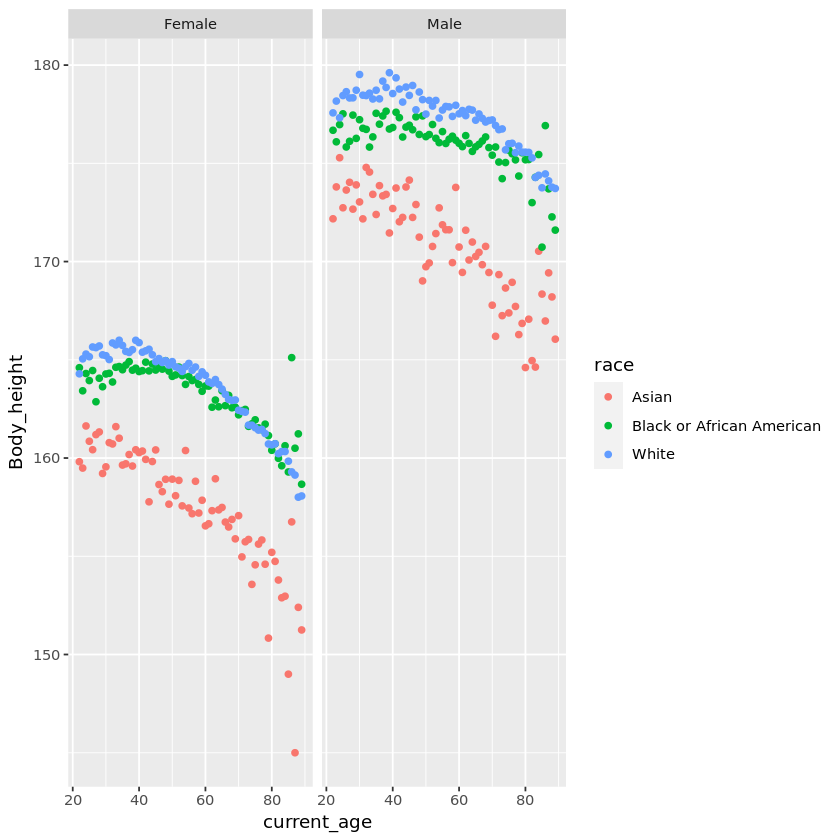

In [5]:
plotdata <- alldata %>% filter(current_age > 21  & current_age < 90 & (sex_at_birth == "Male" | sex_at_birth == "Female")) %>% drop_na() #%>% sample_n(size=200000)

ggplot (plotdata, aes(x = current_age, y = Body_height, color =sex_at_birth)) + 
  stat_summary (fun = mean, geom = "point") 
  #facet_wrap (~ race) # Add facets for different values of race
    
plotdata <- alldata %>% 
        filter(current_age > 21  & 
               current_age < 90 &
               (race == "Asian" | race == "White"  | race== "Black or African American") &
               (sex_at_birth == "Male" | sex_at_birth == "Female")
              ) %>% 
        drop_na() #%>% sample_n(size=200000)

ggplot (plotdata, aes(x = current_age, y = Body_height, color = race)) + 
  stat_summary (fun = mean, geom = "point") +
  facet_wrap (~ sex_at_birth) # 


#hist(plotdata$current_age)

In [6]:
# Load in h2o
if (!require('h2o')) install.packages('h2o')

Loading required package: h2o


----------------------------------------------------------------------

Your next step is to start H2O:
    > h2o.init()

For H2O package documentation, ask for help:
    > ??h2o

After starting H2O, you can use the Web UI at http://localhost:54321
For more information visit https://docs.h2o.ai

----------------------------------------------------------------------



Attaching package: ‘h2o’


The following objects are masked from ‘package:stats’:

    cor, sd, var


The following objects are masked from ‘package:base’:

    &&, %*%, %in%, ||, apply, as.factor, as.numeric, colnames,
    colnames<-, ifelse, is.character, is.factor, is.numeric, log,
    log10, log1p, log2, round, signif, trunc




In [7]:
library(h2o)
#h2o.shutdown(prompt=FALSE)
h2o.init()

 Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         4 minutes 16 seconds 
    H2O cluster timezone:       America/Los_Angeles 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.42.0.2 
    H2O cluster version age:    2 months and 9 days 
    H2O cluster name:           H2O_started_from_R_jupyter_ujl321 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   2.99 GB 
    H2O cluster total cores:    4 
    H2O cluster allowed cores:  4 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    R Version:                  R version 4.2.2 Patched (2022-11-10 r83330) 



# New heading

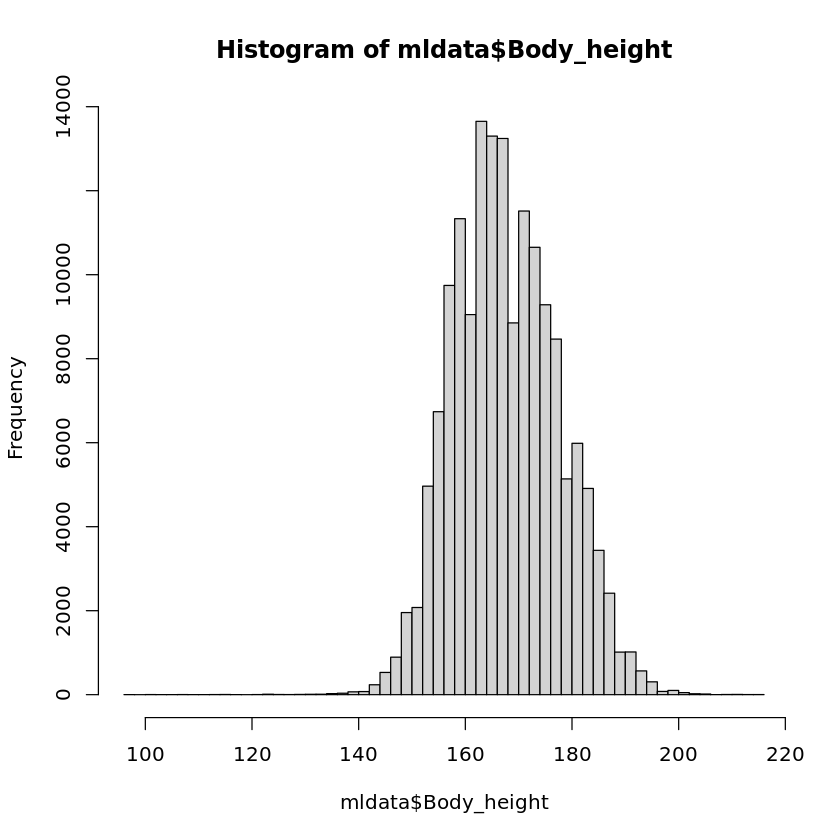

In [8]:
heightdata <- alldata %>% filter(current_age > 21 ) %>% drop_na() #%>% sample_n(size=200000)



#mdata<- alldata %>% filter(sex_at_birth =="Male") %>% drop_na() %>% sample_n(size=10000) 
#fdata<- alldata %>% filter(sex_at_birth =="Female") %>% drop_na() %>% sample_n(size=10000) 

#mldata<-  bind_rows(mdata,fdata) %>% select(person_id,BMI, sex_at_birth,starts_with("avg")) %>% select(1:11)
#mldata$sex_at_birth <- as.factor(mldata$sex_at_birth)


#mldata<-bind_rows(obdata,nonobdata)  %>% 
       # select(person_id,Body_height,sex_at_birth,race,current_age, BMI, obstatus, starts_with("avg")) #%>% 
        #filter(current_age > 30 & current_age < 70) %>% filter(race == "White")

mldata <- heightdata %>% select(person_id,Body_height,sex_at_birth,race,current_age, starts_with("avg"))
mldata$race<-as.factor(mldata$race)
hist(mldata$Body_height, breaks=60)
#mldata
# for the control
# mldata$Body_height <- sample(mldata$Body_height)
#mldata

In [9]:
count(mldata)
train<- mldata %>% sample_frac(0.8)
test <- mldata %>% anti_join(train, by="person_id")
train.hex<- as.h2o(train, destination_frame = "train.hex")  
test.hex<- as.h2o(test, destination_frame = "test.hex")

#train
#test

n
<int>
161820


  |======================================================================| 100%
  |======================================================================| 100%


In [10]:
Sys.time()
model <- h2o.automl(x=5:ncol(train), #5 is age, start at 6 to exclude age
                 y=2,
                 training_frame = train.hex,
                #nfolds=5,
                 max_runtime_secs = training_time,
                 #keep_cross_validation_predictions = TRUE
                   )
Sys.time()

[1] "2023-10-05 10:14:02 PDT"

  |======================================================================| 100%


[1] "2023-10-05 10:15:43 PDT"

In [11]:
winner<- model@leader
#record the AUC in the dataset
 auc=h2o.auc(winner, train=FALSE, xval=TRUE)

# plot out the ROC.  We type out the tissue and AUC at the top of the ROC.
# plot(h2o.performance(winner,train=FALSE, xval=TRUE),type='roc',main='Parkinsons')

#For regression
perf <-h2o.performance(winner,test.hex)
perf

Warning message:
“No cross-validation metrics available.”


H2ORegressionMetrics: stackedensemble

MSE:  53.61532
RMSE:  7.322248
MAE:  5.780931
RMSLE:  0.04353996
Mean Residual Deviance :  53.61532


In [12]:
# get the predictions on the test set
# 
test_predictions <- as.data.frame(h2o.predict(model, test.hex))

#combine with the original data
predictions<-cbind(test_predictions,test)

#predictions

  |======================================================================| 100%


In [13]:
#rank by predicted score ascending
predictions<- predictions %>% arrange(predict) %>% mutate(rank=row_number())
predictions<- predictions %>% select(predict, rank, Body_height, person_id, sex_at_birth, race) %>% arrange(rank)

# Temp print out more, so I can examine
#options(repr.matrix.max.rows=600, repr.matrix.max.cols=200)
#predictions
#options(repr.matrix.max.rows=60, repr.matrix.max.cols=20)

In [14]:
 #h2o.explain(model,newdata = test.hex)

In [15]:
predictions_group <- predictions %>% mutate(group = ntile(predict,50)) %>%
                        group_by(group) %>%
                        summarize(avg_height = mean(Body_height), stdev =sd(Body_height), num=n())

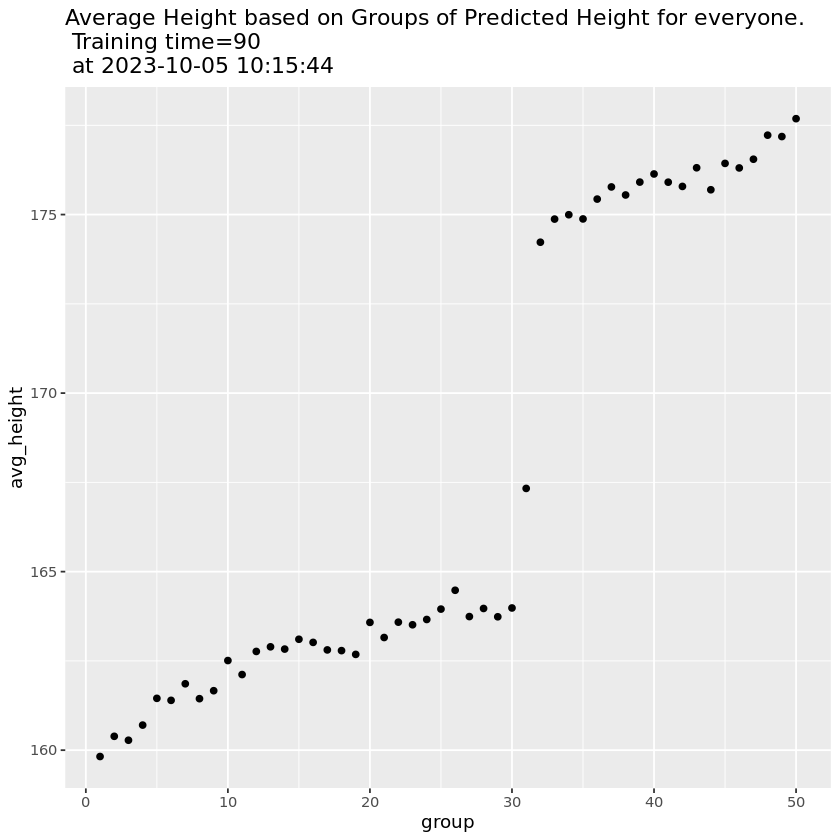

In [16]:
predictions_group$stderr<-predictions_group$stdev/sqrt(predictions_group$num)
#predictions_group
#plot(predictions_group$group,predictions_group$avg_height)
ggplot(predictions_group, aes(group,avg_height)) + 
       geom_point() +
       ggtitle(
           paste0("Average Height based on Groups of Predicted Height for everyone. \n"," Training time=",training_time,"\n at ",Sys.time())
           )

Warning message:
“Removed 5 rows containing non-finite values (`stat_bin()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”


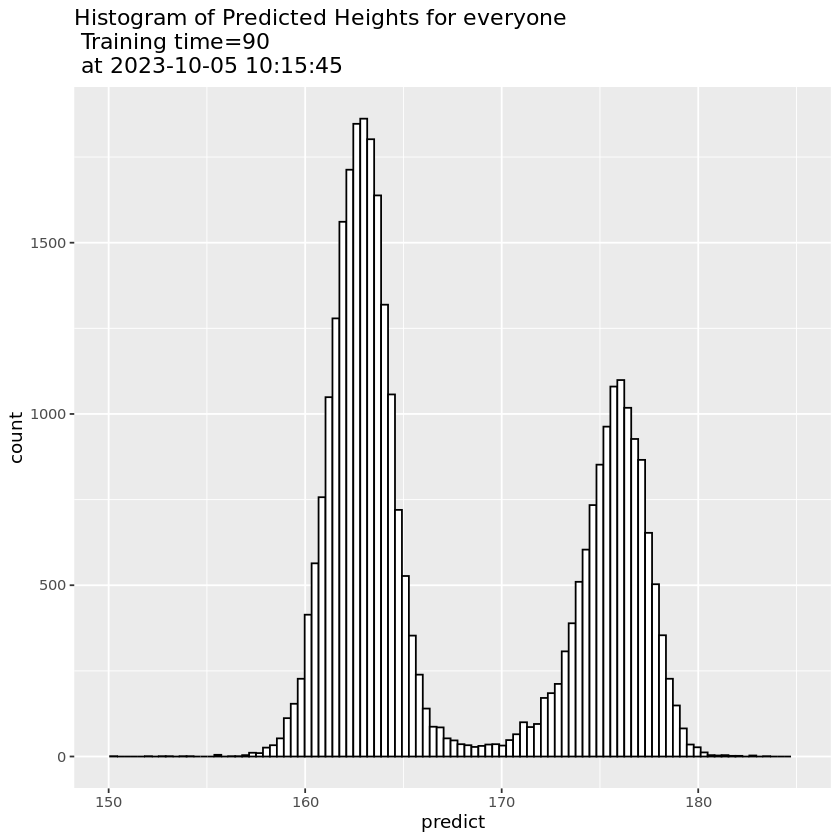

In [17]:
#hist(predictions$predict, breaks=100)
#hist(predictions$Body_height, breaks=50)
ggplot(predictions,aes(predict))+geom_histogram(bins=100, fill="white", color="black")+
        xlim(150,185)+
        ggtitle(paste0("Histogram of Predicted Heights for everyone\n"," Training time=",training_time,"\n at ",Sys.time()))

# Black vs White

In [18]:
blackwhitedata <- alldata %>% filter(current_age > 21  & (race=="White" | race =="Black or African American") )%>% drop_na() #%>% sample_n(size=200000)
bwmldata <- blackwhitedata %>% select(person_id,Body_height,sex_at_birth,current_age,race, starts_with("avg"))
bwmldata$race<-as.factor(bwmldata$race)


#hist(mldata$Body_height, breaks=100)
#mldata
# for the control
# mldata$Body_height <- sample(mldata$Body_height)
mldata<-bwmldata
count(mldata)
#mldata
#head(mldata)

blackonly <- blackwhitedata %>% filter(race=="Black or African American")
count(blackonly)
whiteonly<- blackwhitedata %>% filter(race =="White")
count(whiteonly)

n
<int>
122193


n
<int>
32426


n
<int>
89767


In [19]:
train<- mldata %>% sample_frac(0.8)
test <- mldata %>% anti_join(train, by="person_id")
train.hex<- as.h2o(train, destination_frame = "train.hex")  
test.hex<- as.h2o(test, destination_frame = "test.hex")

#train

  |======================================================================| 100%
  |======================================================================| 100%


In [20]:
Sys.time()
model <- h2o.automl(x=6:ncol(train),
                 y=5,
                 training_frame = train.hex,
                #nfolds=5,
                 max_runtime_secs = training_time,
                 keep_cross_validation_predictions = TRUE
                   )
Sys.time()

[1] "2023-10-05 10:15:51 PDT"

  |======================================================================| 100%


[1] "2023-10-05 10:17:26 PDT"

[1] 0.7205593

[1] 90

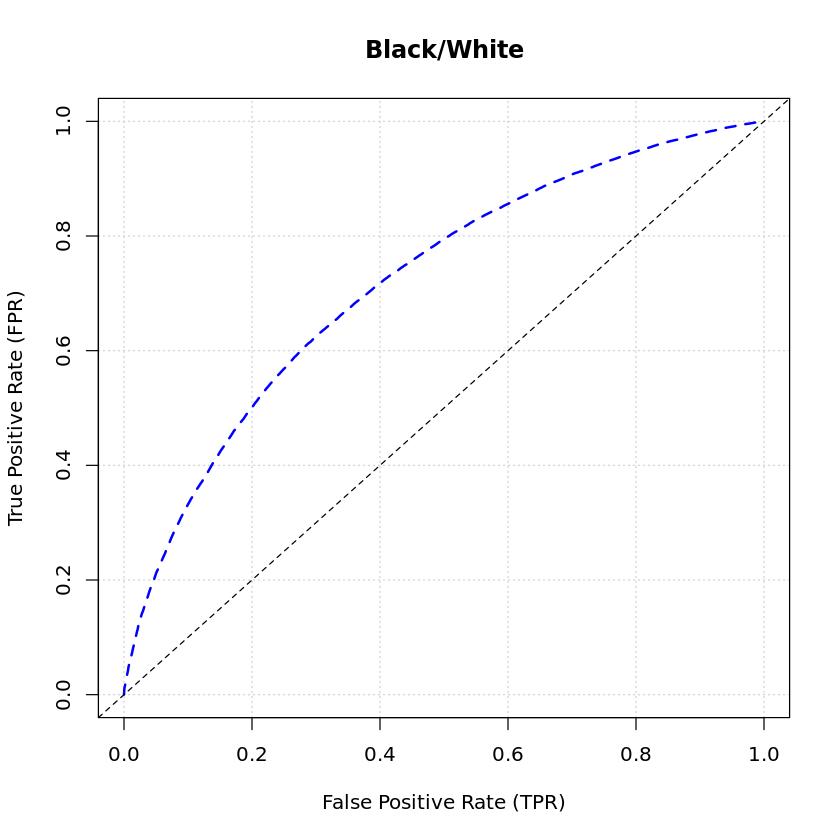

In [21]:
winner<- model@leader
#record the AUC in the dataset
 auc=h2o.auc(winner, train=FALSE, xval=TRUE)

auc
training_time
# plot out the ROC.  We type out the tissue and AUC at the top of the ROC.
 plot(h2o.performance(winner,train=FALSE, xval=TRUE),type='roc',main='Black/White')

#For regression
#perf <-h2o.performance(winner,test.hex)
#perf

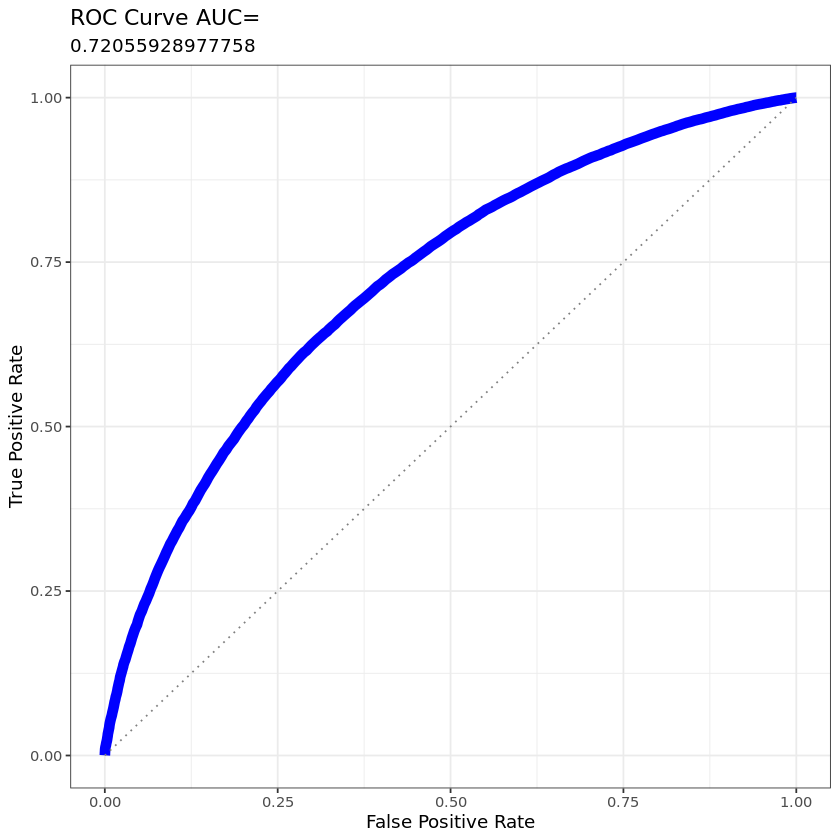

In [22]:
perf_automl <- h2o.performance(winner, xval=TRUE)
automl_curve_dat <- data.frame(perf_automl@metrics$thresholds_and_metric_scores) %>%
  select(c(tpr, fpr))
ggplot() +
  geom_line(data=automl_curve_dat,aes(x=fpr, y=tpr), color="blue", linewidth=3, linetype="solid") +
  geom_segment(
    aes(x = 0, y = 0, xend = 1, yend = 1),
    linetype = "dotted",
    color = "grey50"
  ) +
  xlab("False Positive Rate") +
  ylab("True Positive Rate") +
  ggtitle("ROC Curve AUC= ",perf_automl@metrics$AUC) +
  theme_bw()

# Previous values: 
#   0.80 with 3 minutes training
#   0.97 with 15 minutes training
# 0.9692 with 900 seconds
# 0.9702 with 900 seconds
# 0.9701 with 900 seconds
# 0.9688 with 900 seconds
# 0.9684 with 900 seconds

# White vs Asian

In [23]:
whiteasiandata <- alldata %>% filter(current_age > 21  & (race=="White" | race =="Asian") )%>% drop_na() #%>% sample_n(size=200000)
wamldata <- whiteasiandata %>% select(person_id,Body_height,sex_at_birth,current_age,race, starts_with("avg"))
wamldata$race<-as.factor(wamldata$race)


#hist(mldata$Body_height, breaks=100)
#mldata
# for the control
# mldata$Body_height <- sample(mldata$Body_height)
mldata<-wamldata
count(mldata)
#mldata
#head(mldata)

asianonly<- whiteasiandata %>% filter(race =="Asian")
count(asianonly)

n
<int>
94930


n
<int>
5163


In [24]:
train<- mldata %>% sample_frac(0.8)
test <- mldata %>% anti_join(train, by="person_id")
train.hex<- as.h2o(train, destination_frame = "train.hex")  
test.hex<- as.h2o(test, destination_frame = "test.hex")

#train

  |======================================================================| 100%
  |======================================================================| 100%


In [25]:
Sys.time()
model <- h2o.automl(x=6:ncol(train),
                 y=5,
                 training_frame = train.hex,
                #nfolds=5,
                 max_runtime_secs = training_time,
                 keep_cross_validation_predictions = TRUE
                   )
Sys.time()

[1] "2023-10-05 10:17:31 PDT"

  |======================================================================| 100%


[1] "2023-10-05 10:19:05 PDT"

[1] 0.6394307

[1] 90

                                                 model_id       auc   logloss
1 StackedEnsemble_BestOfFamily_1_AutoML_4_20231005_101731 0.6394307 0.2064571
2                          GLM_1_AutoML_4_20231005_101731 0.6345769 0.2098312
3                          GBM_1_AutoML_4_20231005_101731 0.5804764 0.2097460
4                      XGBoost_1_AutoML_4_20231005_101731 0.5501823 0.2308648
      aucpr mean_per_class_error      rmse        mse
1 0.9656873            0.5000000 0.2261765 0.05115580
2 0.9649451            0.4997657 0.2267052 0.05139524
3 0.9572006            0.5000000 0.2266819 0.05138468
4 0.9524445            0.4994247 0.2347249 0.05509577

[4 rows x 7 columns] 


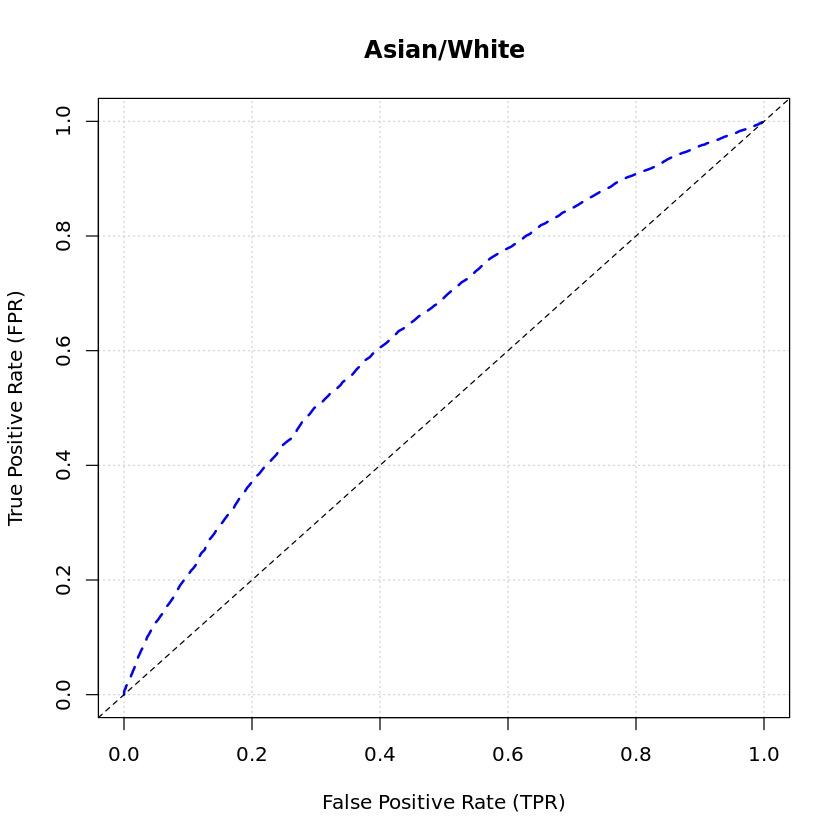

In [26]:
winner<- model@leader
#record the AUC in the dataset
 auc=h2o.auc(winner, train=FALSE, xval=TRUE)

auc
training_time
# plot out the ROC.  We type out the tissue and AUC at the top of the ROC.
 plot(h2o.performance(winner,train=FALSE, xval=TRUE),type='roc',main='Asian/White')

#For regression
#perf <-h2o.performance(winner,test.hex)
#perf

# AUC is 0.876 after 900 seconds
# AUC is 0.879 after 900 seconds
# AUC is 0.876 after 900 seconds
##AUC is 0.879 after 900 seconds
#AUC is 0.878 after 900 seconds

#AUC is 0.968 after 900 seconds

lb <- model@leaderboard
print(lb, n= nrow(lb))


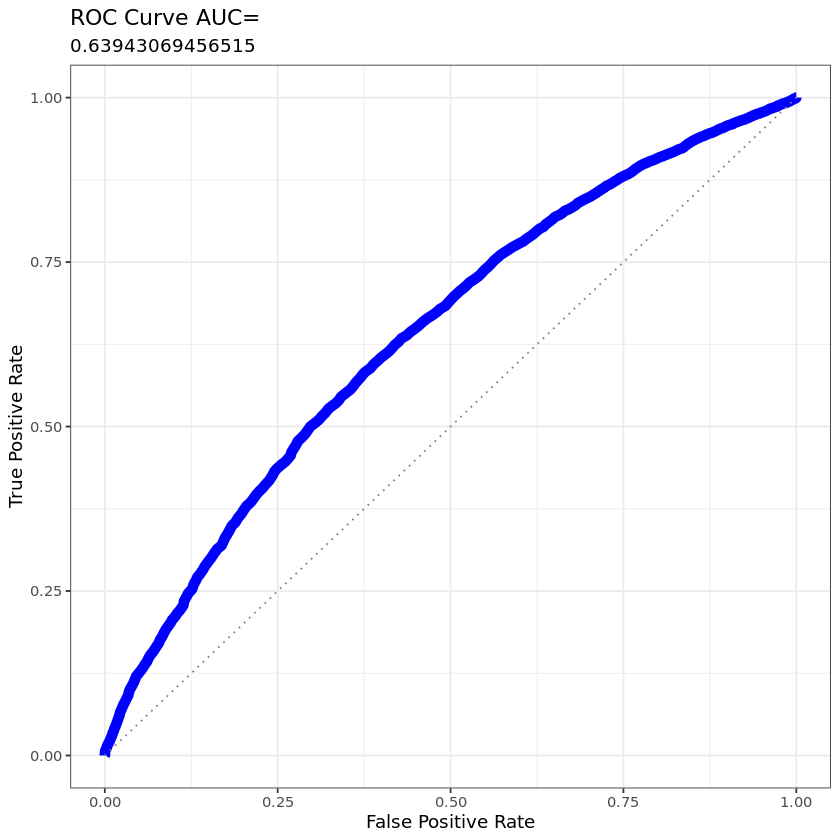

In [27]:
perf_automl <- h2o.performance(winner, xval=TRUE)
automl_curve_dat <- data.frame(perf_automl@metrics$thresholds_and_metric_scores) %>%
  select(c(tpr, fpr))
ggplot() +
  geom_line(data=automl_curve_dat,aes(x=fpr, y=tpr), color="blue", linewidth=3, linetype="solid") +
  geom_segment(
    aes(x = 0, y = 0, xend = 1, yend = 1),
    linetype = "dotted",
    color = "grey50"
  ) +
  xlab("False Positive Rate") +
  ylab("True Positive Rate") +
  ggtitle("ROC Curve AUC= ",perf_automl@metrics$AUC) +
  theme_bw()


# Black vs Asian

In [28]:
blackasiandata <- alldata %>% filter(current_age > 21  & (race=="Black or African American" | race =="Asian") )%>% drop_na() #%>% sample_n(size=200000)
bamldata <- blackasiandata %>% select(person_id,Body_height,sex_at_birth,current_age,race, starts_with("avg"))
bamldata$race<-as.factor(bamldata$race)


#hist(mldata$Body_height, breaks=100)
#mldata
# for the control
# mldata$Body_height <- sample(mldata$Body_height)
mldata<-bamldata
count(mldata)
#mldata
#head(mldata)

n
<int>
37589


In [29]:
train<- mldata %>% sample_frac(0.8)
test <- mldata %>% anti_join(train, by="person_id")
train.hex<- as.h2o(train, destination_frame = "train.hex")  
test.hex<- as.h2o(test, destination_frame = "test.hex")

#train

  |======================================================================| 100%
  |======================================================================| 100%


In [30]:
Sys.time()
model <- h2o.automl(x=6:ncol(train),
                 y=5,
                 training_frame = train.hex,
                #nfolds=5,
                 max_runtime_secs = training_time,
                 keep_cross_validation_predictions = TRUE
                   )
Sys.time()

[1] "2023-10-05 10:19:09 PDT"

  |======================================================================| 100%


[1] "2023-10-05 10:20:45 PDT"

[1] 0.9396281

[1] 90

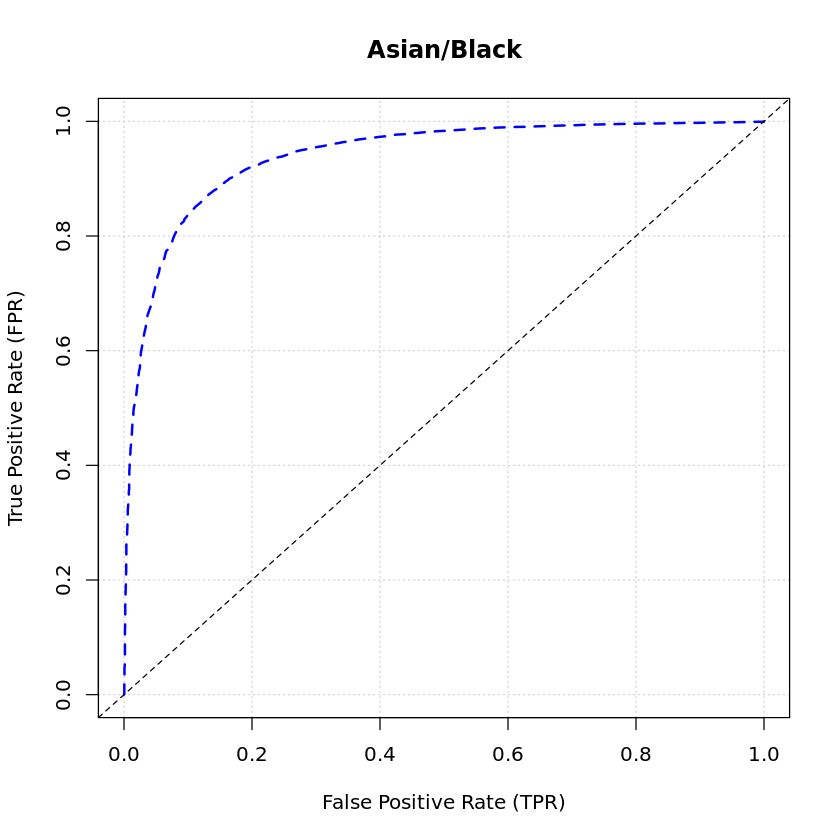

In [31]:
winner<- model@leader
#record the AUC in the dataset
 auc=h2o.auc(winner, train=FALSE, xval=TRUE)

auc
training_time
# plot out the ROC.  We type out the tissue and AUC at the top of the ROC.
 plot(h2o.performance(winner,train=FALSE, xval=TRUE),type='roc',main='Asian/Black')

# AUC 0.967 900 seconds
# AUC 0.966 900 seconds
# AUC 0.967 900 seconds

# AUC 0.9666 900 seconds
# AUC 0.9664 900 seconds
#AUC

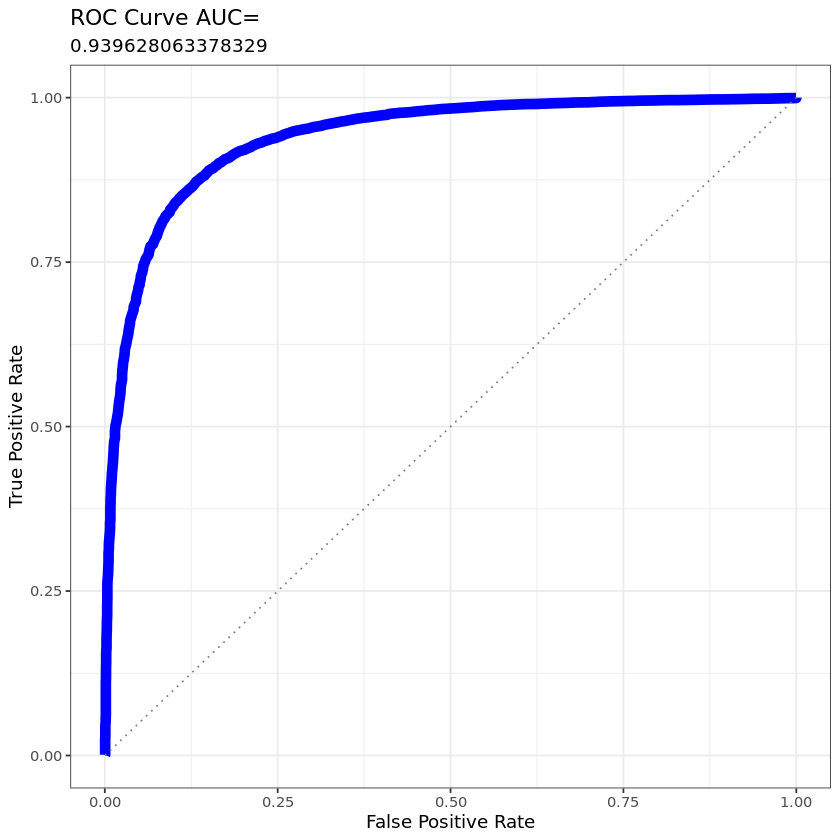

In [32]:
perf_automl <- h2o.performance(winner, xval=TRUE)
automl_curve_dat <- data.frame(perf_automl@metrics$thresholds_and_metric_scores) %>%
  select(c(tpr, fpr))
ggplot() +
  geom_line(data=automl_curve_dat,aes(x=fpr, y=tpr), color="blue", linewidth=3, linetype="solid") +
  geom_segment(
    aes(x = 0, y = 0, xend = 1, yend = 1),
    linetype = "dotted",
    color = "grey50"
  ) +
  xlab("False Positive Rate") +
  ylab("True Positive Rate") +
  ggtitle("ROC Curve AUC= ",perf_automl@metrics$AUC) +
  theme_bw()

# Male/Female

In [33]:
mfalldata <- alldata %>% filter(current_age > 21  & (sex_at_birth =="Male") | (sex_at_birth =="Female") )%>% drop_na() #%>% sample_n(size=200000)
mfdata <- mfalldata %>% select(person_id,Body_height,sex_at_birth,current_age,race, starts_with("avg"))
mfdata$sex_at_birth<-as.factor(mfdata$sex_at_birth)


#hist(mldata$Body_height, breaks=100)
#mldata
# for the control
# mldata$Body_height <- sample(mldata$Body_height)
mldata<-mfdata
count(mldata)
#mldata
#head(mldata)
monly <- mfdata %>% filter(sex_at_birth =="Male")
fonly <- mfdata %>% filter(sex_at_birth =="Female")

count(monly)
count(fonly)

n
<int>
159779


n
<int>
62090


n
<int>
97689


In [34]:
train<- mldata %>% sample_frac(0.8)
test <- mldata %>% anti_join(train, by="person_id")
train.hex<- as.h2o(train, destination_frame = "train.hex")  
test.hex<- as.h2o(test, destination_frame = "test.hex")

#train

  |======================================================================| 100%
  |======================================================================| 100%


In [35]:
Sys.time()
model <- h2o.automl(x=6:ncol(train),
                 y=3,
                 training_frame = train.hex,
                #nfolds=5,
                 max_runtime_secs = training_time,
                 keep_cross_validation_predictions = TRUE
                   )
Sys.time()

[1] "2023-10-05 10:20:53 PDT"

  |======================================================================| 100%


[1] "2023-10-05 10:22:31 PDT"

[1] 0.9983127

[1] 90

                                                 model_id       auc    logloss
1 StackedEnsemble_BestOfFamily_1_AutoML_6_20231005_102053 0.9983127 0.03448411
2                          GBM_1_AutoML_6_20231005_102053 0.9980557 0.38652398
3                      XGBoost_1_AutoML_6_20231005_102053 0.9978237 0.21715692
4                          GLM_1_AutoML_6_20231005_102053 0.7175398 0.62567363
      aucpr mean_per_class_error       rmse         mse
1 0.9979614           0.01156855 0.09225728 0.008511406
2 0.9975171           0.01491313 0.32631098 0.106478858
3 0.9971481           0.01467825 0.20708030 0.042882251
4 0.5983822           0.35029535 0.46644931 0.217574958

[4 rows x 7 columns] 


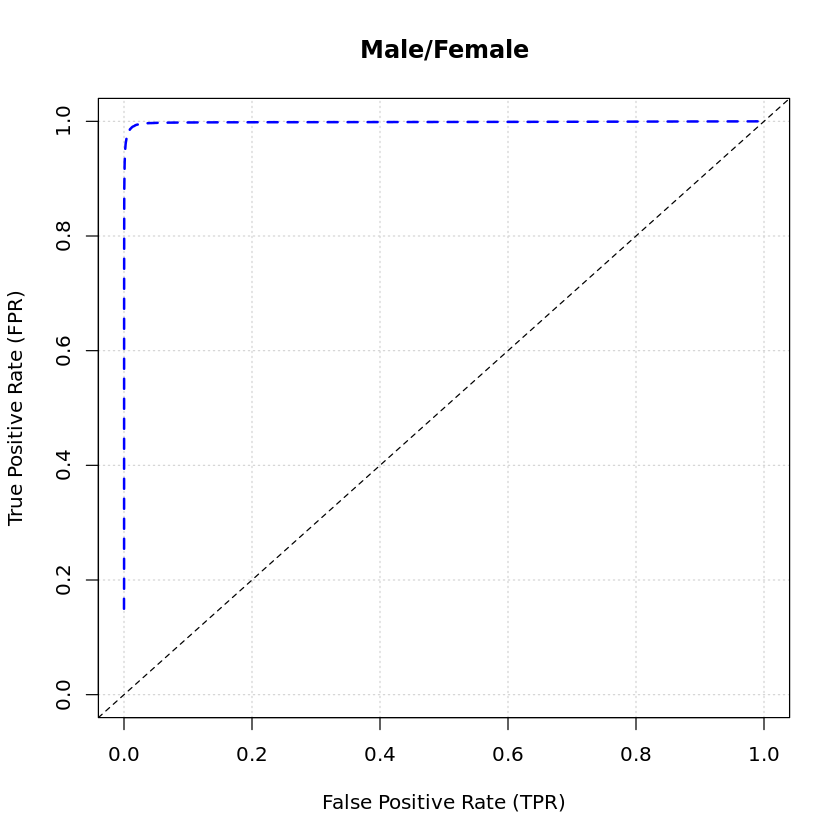

In [36]:
winner<- model@leader
#record the AUC in the dataset
 auc=h2o.auc(winner, train=FALSE, xval=TRUE)

auc
training_time
# plot out the ROC.  We type out the tissue and AUC at the top of the ROC.
 plot(h2o.performance(winner,train=FALSE, xval=TRUE),type='roc',main='Male/Female')

# AUC 0.9988  for 15 minutes
# AUC 0.9989
# AUC 0.9989
# AUC 0.9988
# AUC 0.9989

lb <- model@leaderboard
print(lb, n= nrow(lb))


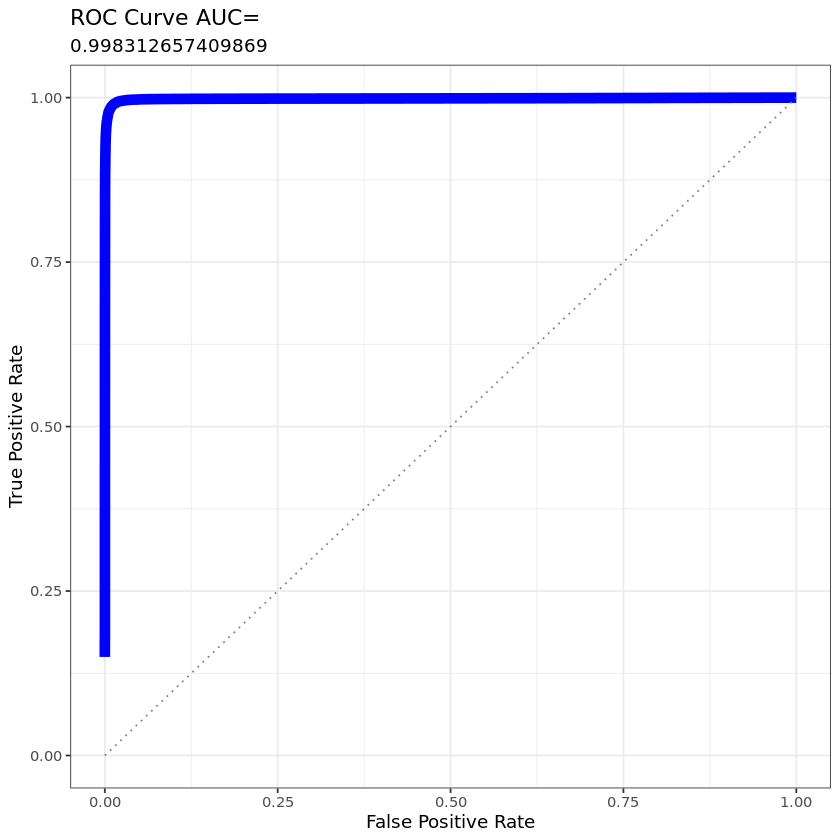

In [37]:
perf_automl <- h2o.performance(winner, xval=TRUE)
automl_curve_dat <- data.frame(perf_automl@metrics$thresholds_and_metric_scores) %>%
  select(c(tpr, fpr))
ggplot() +
  geom_line(data=automl_curve_dat,aes(x=fpr, y=tpr), color="blue", linewidth=3, linetype="solid") +
  geom_segment(
    aes(x = 0, y = 0, xend = 1, yend = 1),
    linetype = "dotted",
    color = "grey50"
  ) +
  xlab("False Positive Rate") +
  ylab("True Positive Rate") +
  ggtitle("ROC Curve AUC= ",perf_automl@metrics$AUC) +
  theme_bw()